In [1]:
import pandas as pd
import numpy as np
import math
from itertools import combinations
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')
import subprocess
from adjustText import adjust_text
import scanpy as sc
sc.settings.verbosiforty = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import anndata as ad
import scipy.sparse as sp
import scanpy.external as sce

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.6 pynndescent==0.5.13


## Figure 7B 

In [6]:
tumor_dc = sc.read_h5ad('tumor_dc.h5ad')

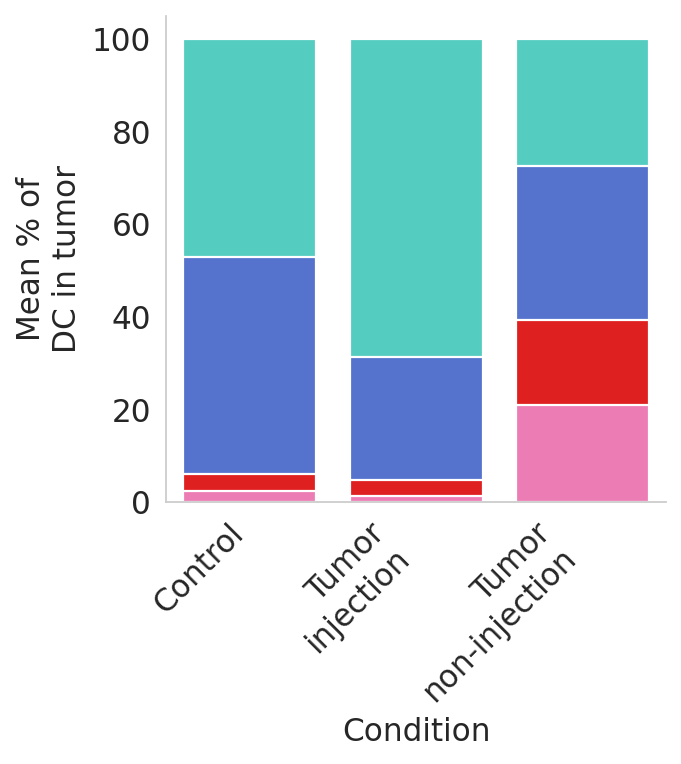

In [8]:
quant = tumor_dc.obs.groupby(by = ['patient','timepoint',])[['total_counts']].count().reset_index()
quant_s = tumor_dc.obs.groupby(by = ['patient','timepoint','cellstate'])[['ident']].count().reset_index()

quant['pateint_loc'] = quant['timepoint'].astype(str) +quant['patient'].astype(str) 
quant_s['pateint_loc'] = quant_s['timepoint'].astype(str) +quant_s['patient'].astype(str) 

m = quant.merge(quant_s, left_on = 'pateint_loc', right_on  ='pateint_loc')
m['timepoint_y'] = m['timepoint_y'].astype(str)
m.loc[m.timepoint_y=='tumor','timepoint_y' ] = 'control'
m.loc[m.timepoint_y=='tumor_inj','timepoint_y' ] = 'Injected'
m.loc[m.timepoint_y=='tumor_nin','timepoint_y' ] = 'Non-injected'
m['perc'] = m['ident']/m['total_counts']*100
m = m.dropna()

s = m.groupby(by = ['cellstate', 
                    'timepoint_x'])[['perc']].mean().reset_index().pivot_table(index = 'timepoint_x', 
                                                                           columns = 'cellstate', values = 'perc').T

s = s.sort_values(by = ['tumor_inj'],ascending = True)

s = s.cumsum()
s = s.sort_values(by = ['tumor_inj'],ascending = False)
melt = s.reset_index().melt(id_vars = 'cellstate', )
melt['timepoint_x'] = melt['timepoint_x'].map({'tumor':'Control',
                                               'tumor_inj':'Tumor\ninjection','tumor_nin':'Tumor\nnon-injection'})

palette = {'CCR7+ IRF8+':'turquoise', 'Inflammatory cDC2':'royalblue', 'Anti-inflammatory cDC2':'hotpink', 'cDC1':'red', 
           'Stem-like':'skyblue',  'Proliferation':'gold',
           'Effector':'pink', 'T-reg':'purple',
           'Cytotoxic T cells':'pink',  'Exhausted':'brown',
                                                      'Inflammatory':'orange', 'Naive':'skyblue', 'Treg':'purple'}

for name in s.index:
    sns.barplot(data = melt[melt['cellstate'] == name],
            x = 'timepoint_x', y ='value', color= palette[name])
    plt.xlabel('Condition')
    plt.xticks(rotation = 45, ha ='right')
    plt.ylabel('Mean % of\nDC in tumor')
    sns.despine(top = True)
plt.show()

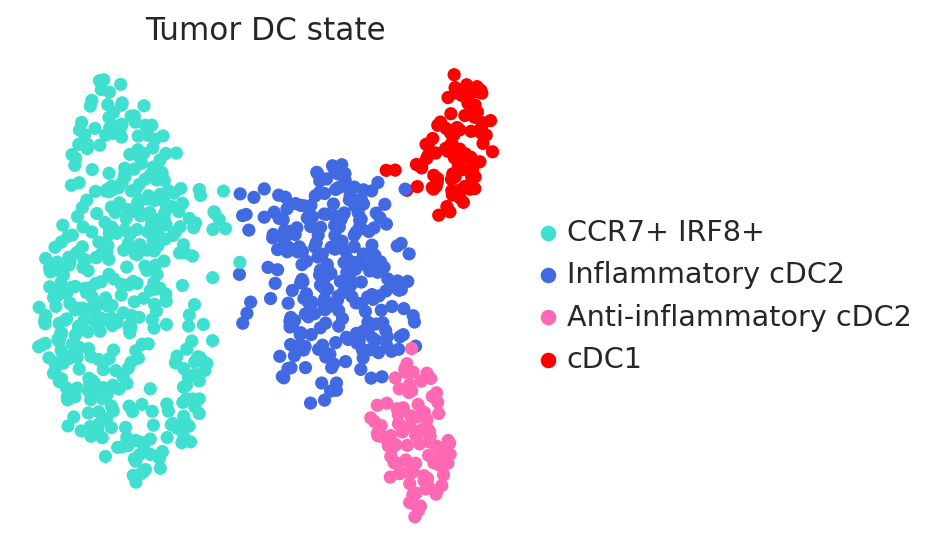

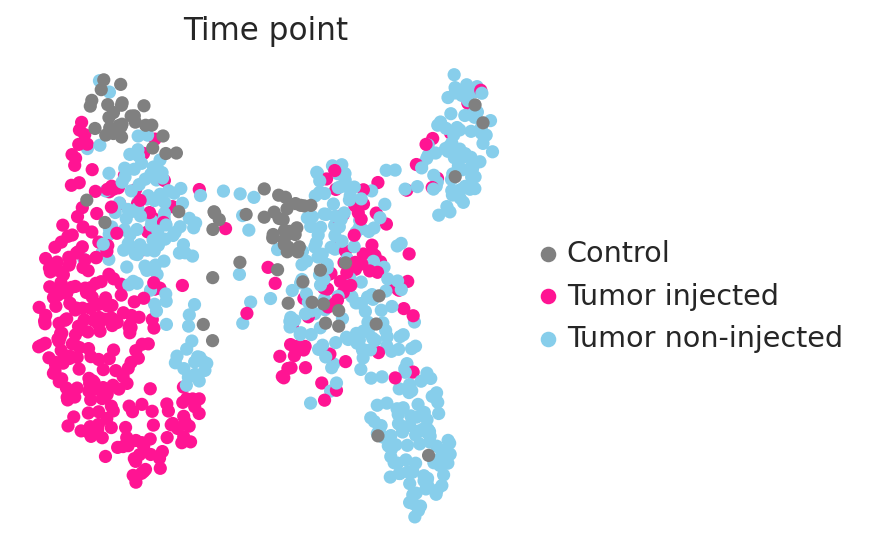

In [9]:
tumor_dc.obs['timepoint_annot'] = tumor_dc.obs['timepoint'].map({'tumor':'Control','tumor_inj':'Tumor injected','tumor_nin':'Tumor non-injected'})
sc.pl.umap(tumor_dc,color = [ 'cellstate'],
           palette = {'CCR7+ IRF8+':'turquoise', 'Inflammatory cDC2':'royalblue', 'Anti-inflammatory cDC2':'hotpink', 'cDC1':'red', 
           'Stem-like':'skyblue',  'Proliferation':'gold',
           'Effector':'pink', 'T-reg':'purple',
           'Cytotoxic T cells':'pink',  'Exhausted':'brown', 
                      'Inflammatory':'orange', 'Naive':'skyblue', 'Treg':'purple'}, vmin =0, vmax= 6, cmap = 'seismic',
           title = ['Tumor DC state'],
         #  legend_loc= 'on data',
           frameon = False)

sc.pl.umap(tumor_dc,color = [ 'timepoint_annot'],
           palette = {'Control':'grey','Tumor injected':'deeppink','Tumor non-injected':'skyblue'},
         vmin =0, vmax= 6, cmap = 'seismic', title = ['Time point'],
           frameon = False)

## Figure 7C

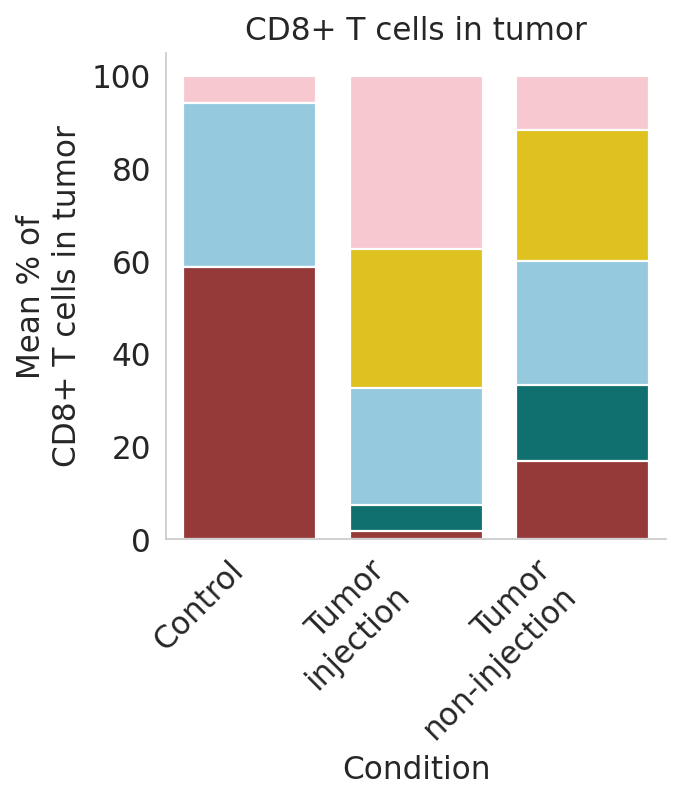

In [3]:
tumor_cd8 = sc.read_h5ad('tumor_cd8_final.h5ad')

quant = tumor_cd8.obs.groupby(by = ['patient','timepoint',])[['total_counts']].count().reset_index()
quant_s = tumor_cd8.obs.groupby(by = ['patient','timepoint','cellstate'])[['ident']].count().reset_index()

quant['pateint_loc'] = quant['timepoint'].astype(str) +quant['patient'].astype(str) 
quant_s['pateint_loc'] = quant_s['timepoint'].astype(str) +quant_s['patient'].astype(str) 

m = quant.merge(quant_s, left_on = 'pateint_loc', right_on  ='pateint_loc')
m['perc'] = m['ident']/m['total_counts']*100
m = m.dropna()

s = m.groupby(by = ['cellstate', 
                    'timepoint_x'])[['perc']].mean().reset_index().pivot_table(index = 'timepoint_x', 
                                                                           columns = 'cellstate', values = 'perc').T

s = s.sort_values(by = ['tumor_inj'],ascending = True)

s = s.cumsum()
s = s.sort_values(by = ['tumor_inj'],ascending = False)
melt = s.reset_index().melt(id_vars = 'cellstate', )
melt['timepoint_x'] = melt['timepoint_x'].map({'tumor':'Control',
                                               'tumor_inj':'Tumor\ninjection',
                                               'tumor_nin':'Tumor\nnon-injection'})

palette = {'Stem-like':'skyblue',  
             'Proliferation':'gold', 
             'Effector memory':'teal', 
             'Effector':'pink',  
             'T-reg':'purple',
             'Pre-exhausted':'orange', 
             'Exhausted':'brown',  }

for name in s.index:
    sns.barplot(data = melt[melt['cellstate'] == name],
            x = 'timepoint_x', y ='value', color= palette[name])
    plt.xlabel('Condition')
    plt.xticks(rotation = 45, ha ='right')
    plt.ylabel('Mean % of\nCD8+ T cells in tumor')
    sns.despine(top = True)
plt.title('CD8+ T cells in tumor')
plt.show()

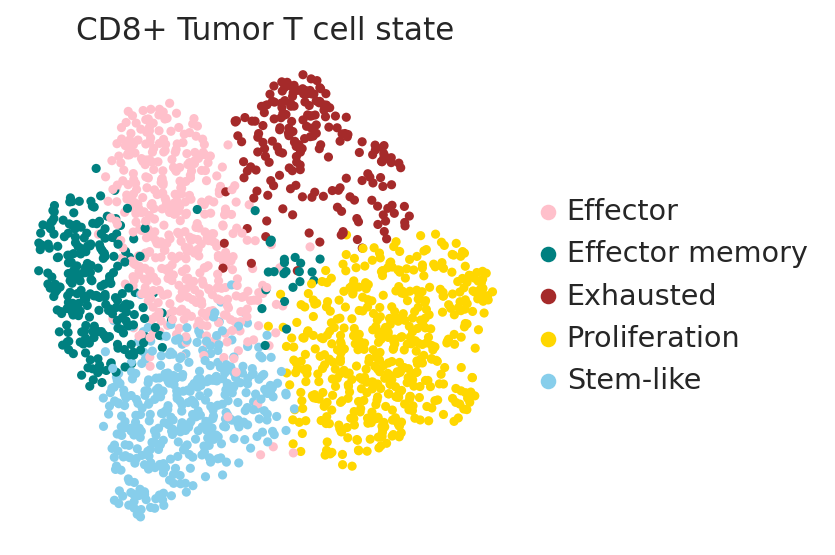

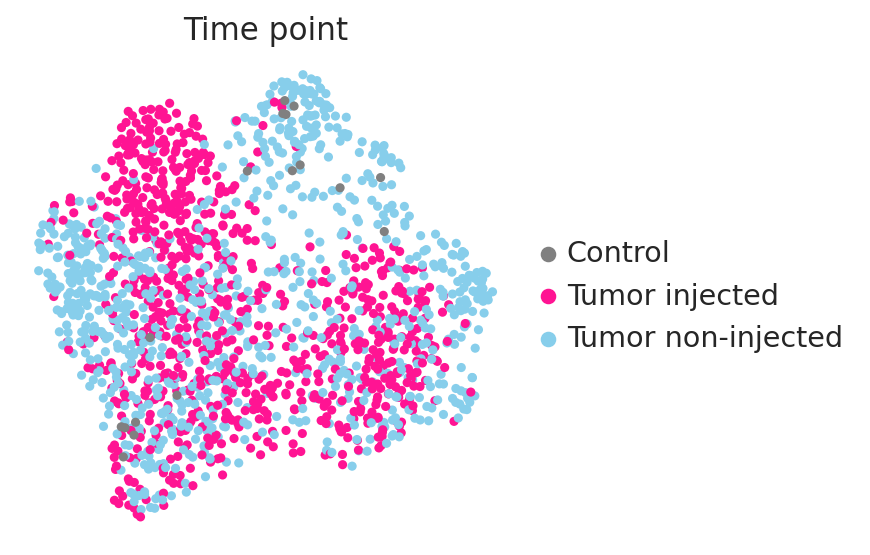

In [5]:
sc.pl.umap(tumor_cd8,color = [ 'cellstate'],
           palette = {'Stem-like':'skyblue',  
             'Proliferation':'gold', 
             'Effector memory':'teal', 
             'Effector':'pink',  
             'T-reg':'purple',
             'Pre-exhausted':'orange', 
             'Exhausted':'brown',  }, vmin =0, vmax= 6, cmap = 'seismic',
           title = ['CD8+ Tumor T cell state'],
         #  legend_loc= 'on data',
           frameon = False)

tumor_cd8.obs['timepoint_annot'] = tumor_cd8.obs['timepoint'].map({'tumor':'Control','tumor_inj':'Tumor injected','tumor_nin':'Tumor non-injected'})
sc.pl.umap(tumor_cd8,color = [ 'timepoint_annot'],
           palette = {'Control':'grey','Tumor injected':'deeppink','Tumor non-injected':'skyblue'},
         vmin =0, vmax= 6, cmap = 'seismic', title = ['Time point'],
           frameon = False)

## Figure 7D

In [24]:
tumor_cd8_tcr = pd.read_csv('tumor_mouse_cd8_tcr.csv',sep = '\t')

In [25]:
## Ground truth 
def permute_enrich(k):
    d_list =[ ]
    for i in ['1','2','3']:
        j_dict= {'s1':[], 's2':[], 'jaccard':[]}

        ### permutate label 
        subset1 = tumor_cd8_tcr[tumor_cd8_tcr['id'] == f'tumor_inj|{i}']
        subset1['shuffle'] = np.random.permutation(subset1['cellstate'].values)

        subset2 = tumor_cd8_tcr[tumor_cd8_tcr['id'] == f'tumor_nin|{i}']
        subset2['shuffle'] = np.random.permutation(subset2['cellstate'].values)
        
        for state1 in tumor_cd8_tcr[tumor_cd8_tcr['id'] == f'tumor_inj|{i}'].id_state.unique():
            for state2 in  tumor_cd8_tcr[tumor_cd8_tcr['id'] == f'tumor_nin|{i}'].id_state.unique():
                
                s1 = set(subset1[subset1['shuffle'] == state1].beta_cdr3)
                s2 = set(subset2[subset2['shuffle'] == state2].beta_cdr3)
                
                if (len(s1)>=10) & (len(s2)>=10):
                    jaccard = len(set(s1).intersection(set(s2)))/len(set(s1).union(set(s2)))
                    j_dict['s1'].append(state1.split('|')[-1])
                    j_dict['s2'].append(state2.split('|')[-1])
                    j_dict['jaccard'].append(jaccard)
        df = pd.DataFrame(j_dict)
        df['patient'] = i
        d_list.append(df)
    comb = pd.concat(d_list).groupby(by  = ['s1','s2']).mean()
    comb.columns = [k]
    return comb

## Ground truth 
d_list =[ ]
for i in ['1','2','3']:
    j_dict= {'s1':[], 's2':[], 'jaccard':[]}
    for state1 in tumor_cd8_tcr[tumor_cd8_tcr['id'] == f'tumor_inj|{i}'].id_state.unique():
        for state2 in  tumor_cd8_tcr[tumor_cd8_tcr['id'] == f'tumor_nin|{i}'].id_state.unique():
            #print(state1, state2)
            s1 = set(tumor_cd8_tcr[tumor_cd8_tcr['id_state'] == state1].beta_cdr3)
            s2 = set(tumor_cd8_tcr[tumor_cd8_tcr['id_state'] == state2].beta_cdr3)
            if (len(s1)>=10) & (len(s2)>=10):
                jaccard = len(set(s1).intersection(set(s2)))/len(set(s1).union(set(s2)))
                j_dict['s1'].append(state1.split('|')[-1])
                j_dict['s2'].append(state2.split('|')[-1])
                j_dict['jaccard'].append(jaccard)
    df = pd.DataFrame(j_dict)
    d_list.append(df)
comb = pd.concat(d_list)
truth = comb.groupby(by  = ['s1','s2']).mean()
truth.columns = ['target']

In [26]:
N = 500
p_list =[] 
for k in np.arange(N):
    p_list.append( permute_enrich(k))
perm = pd.concat(p_list, axis= 1)
s = pd.concat([truth, perm], axis= 1)
d_list =[] 
for i in np.arange(N):
    d_list.append(s['target']<=s[i])
pval = pd.DataFrame(pd.concat(d_list, axis= 1).sum(axis= 1))/N

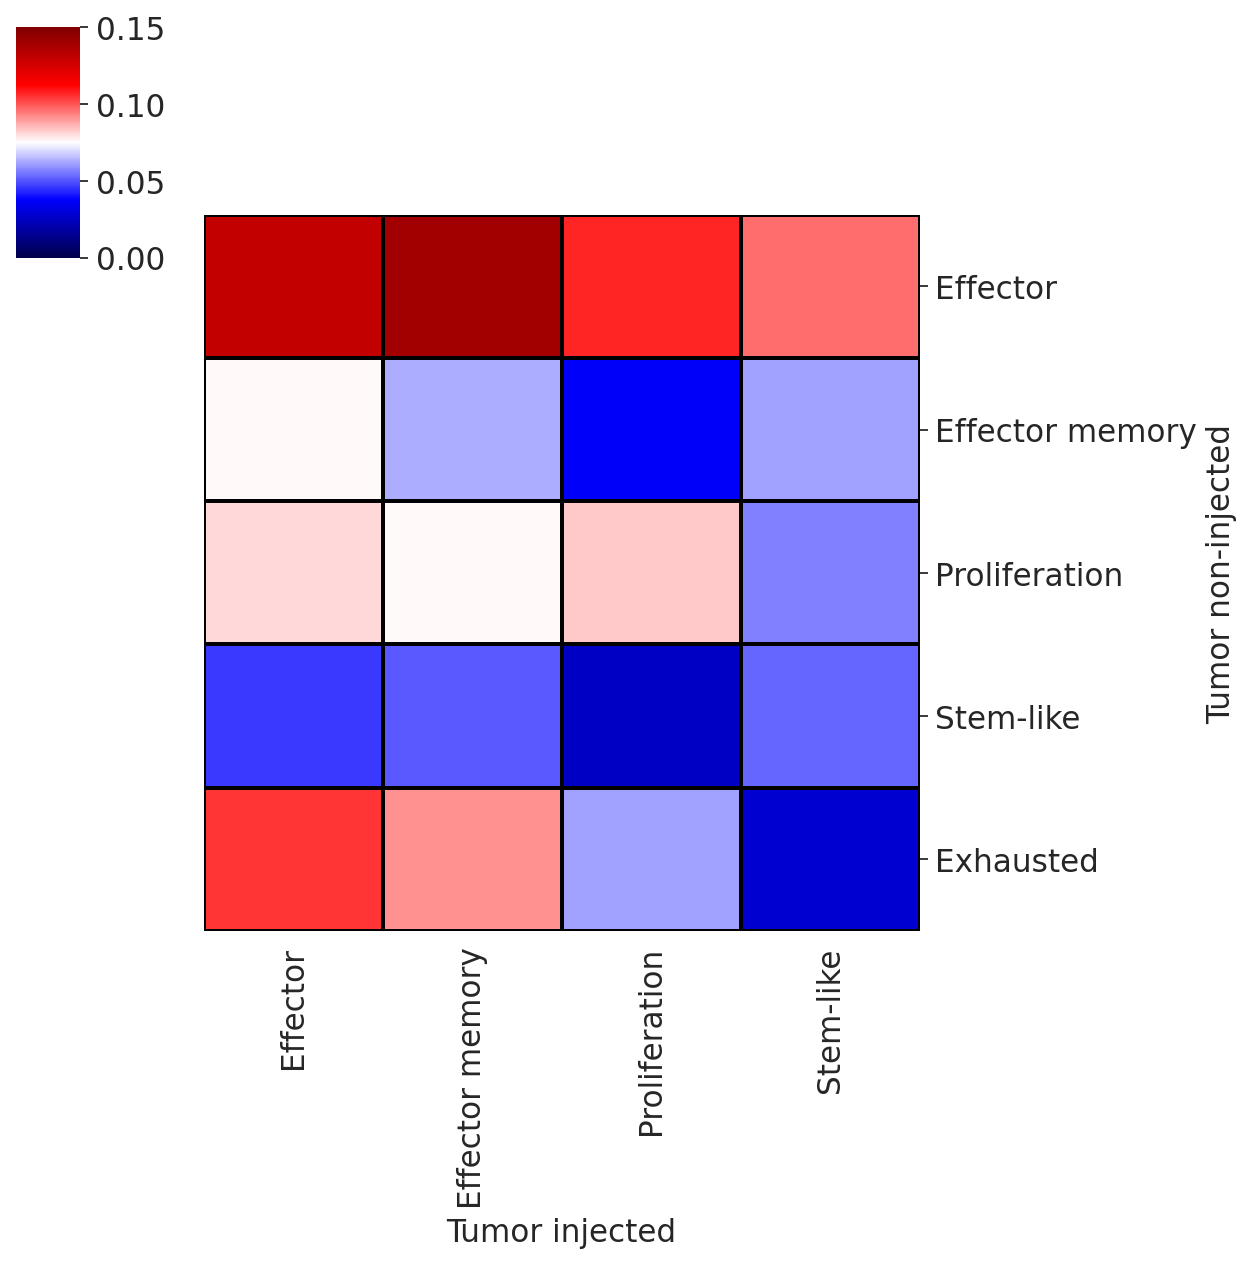

In [27]:
enrich =  pd.concat([ truth, pval ] ,axis= 1)
enrich = enrich[enrich[0]<0.05].reset_index().pivot_table(index = 's2', columns = 's1', values = 'target')
enrich[enrich.isna()] = 0 
enrich.columns.names = ['Tumor injected']
enrich.index.names = ['Tumor non-injected']
enrich = enrich[['Effector','Effector memory','Proliferation','Stem-like']].T[['Effector','Effector memory','Proliferation','Stem-like','Exhausted']]
enrich = enrich.T
sns.clustermap(enrich, vmin = 0, vmax= 0.15, 
               mask = enrich ==0, 
               col_cluster = False, row_cluster =  False, 
               figsize=(8,8),linecolor= 'black', linewidth = 1, 
               edgecolor = 'white', cmap = 'seismic')
plt.show()

## Supplement 6A

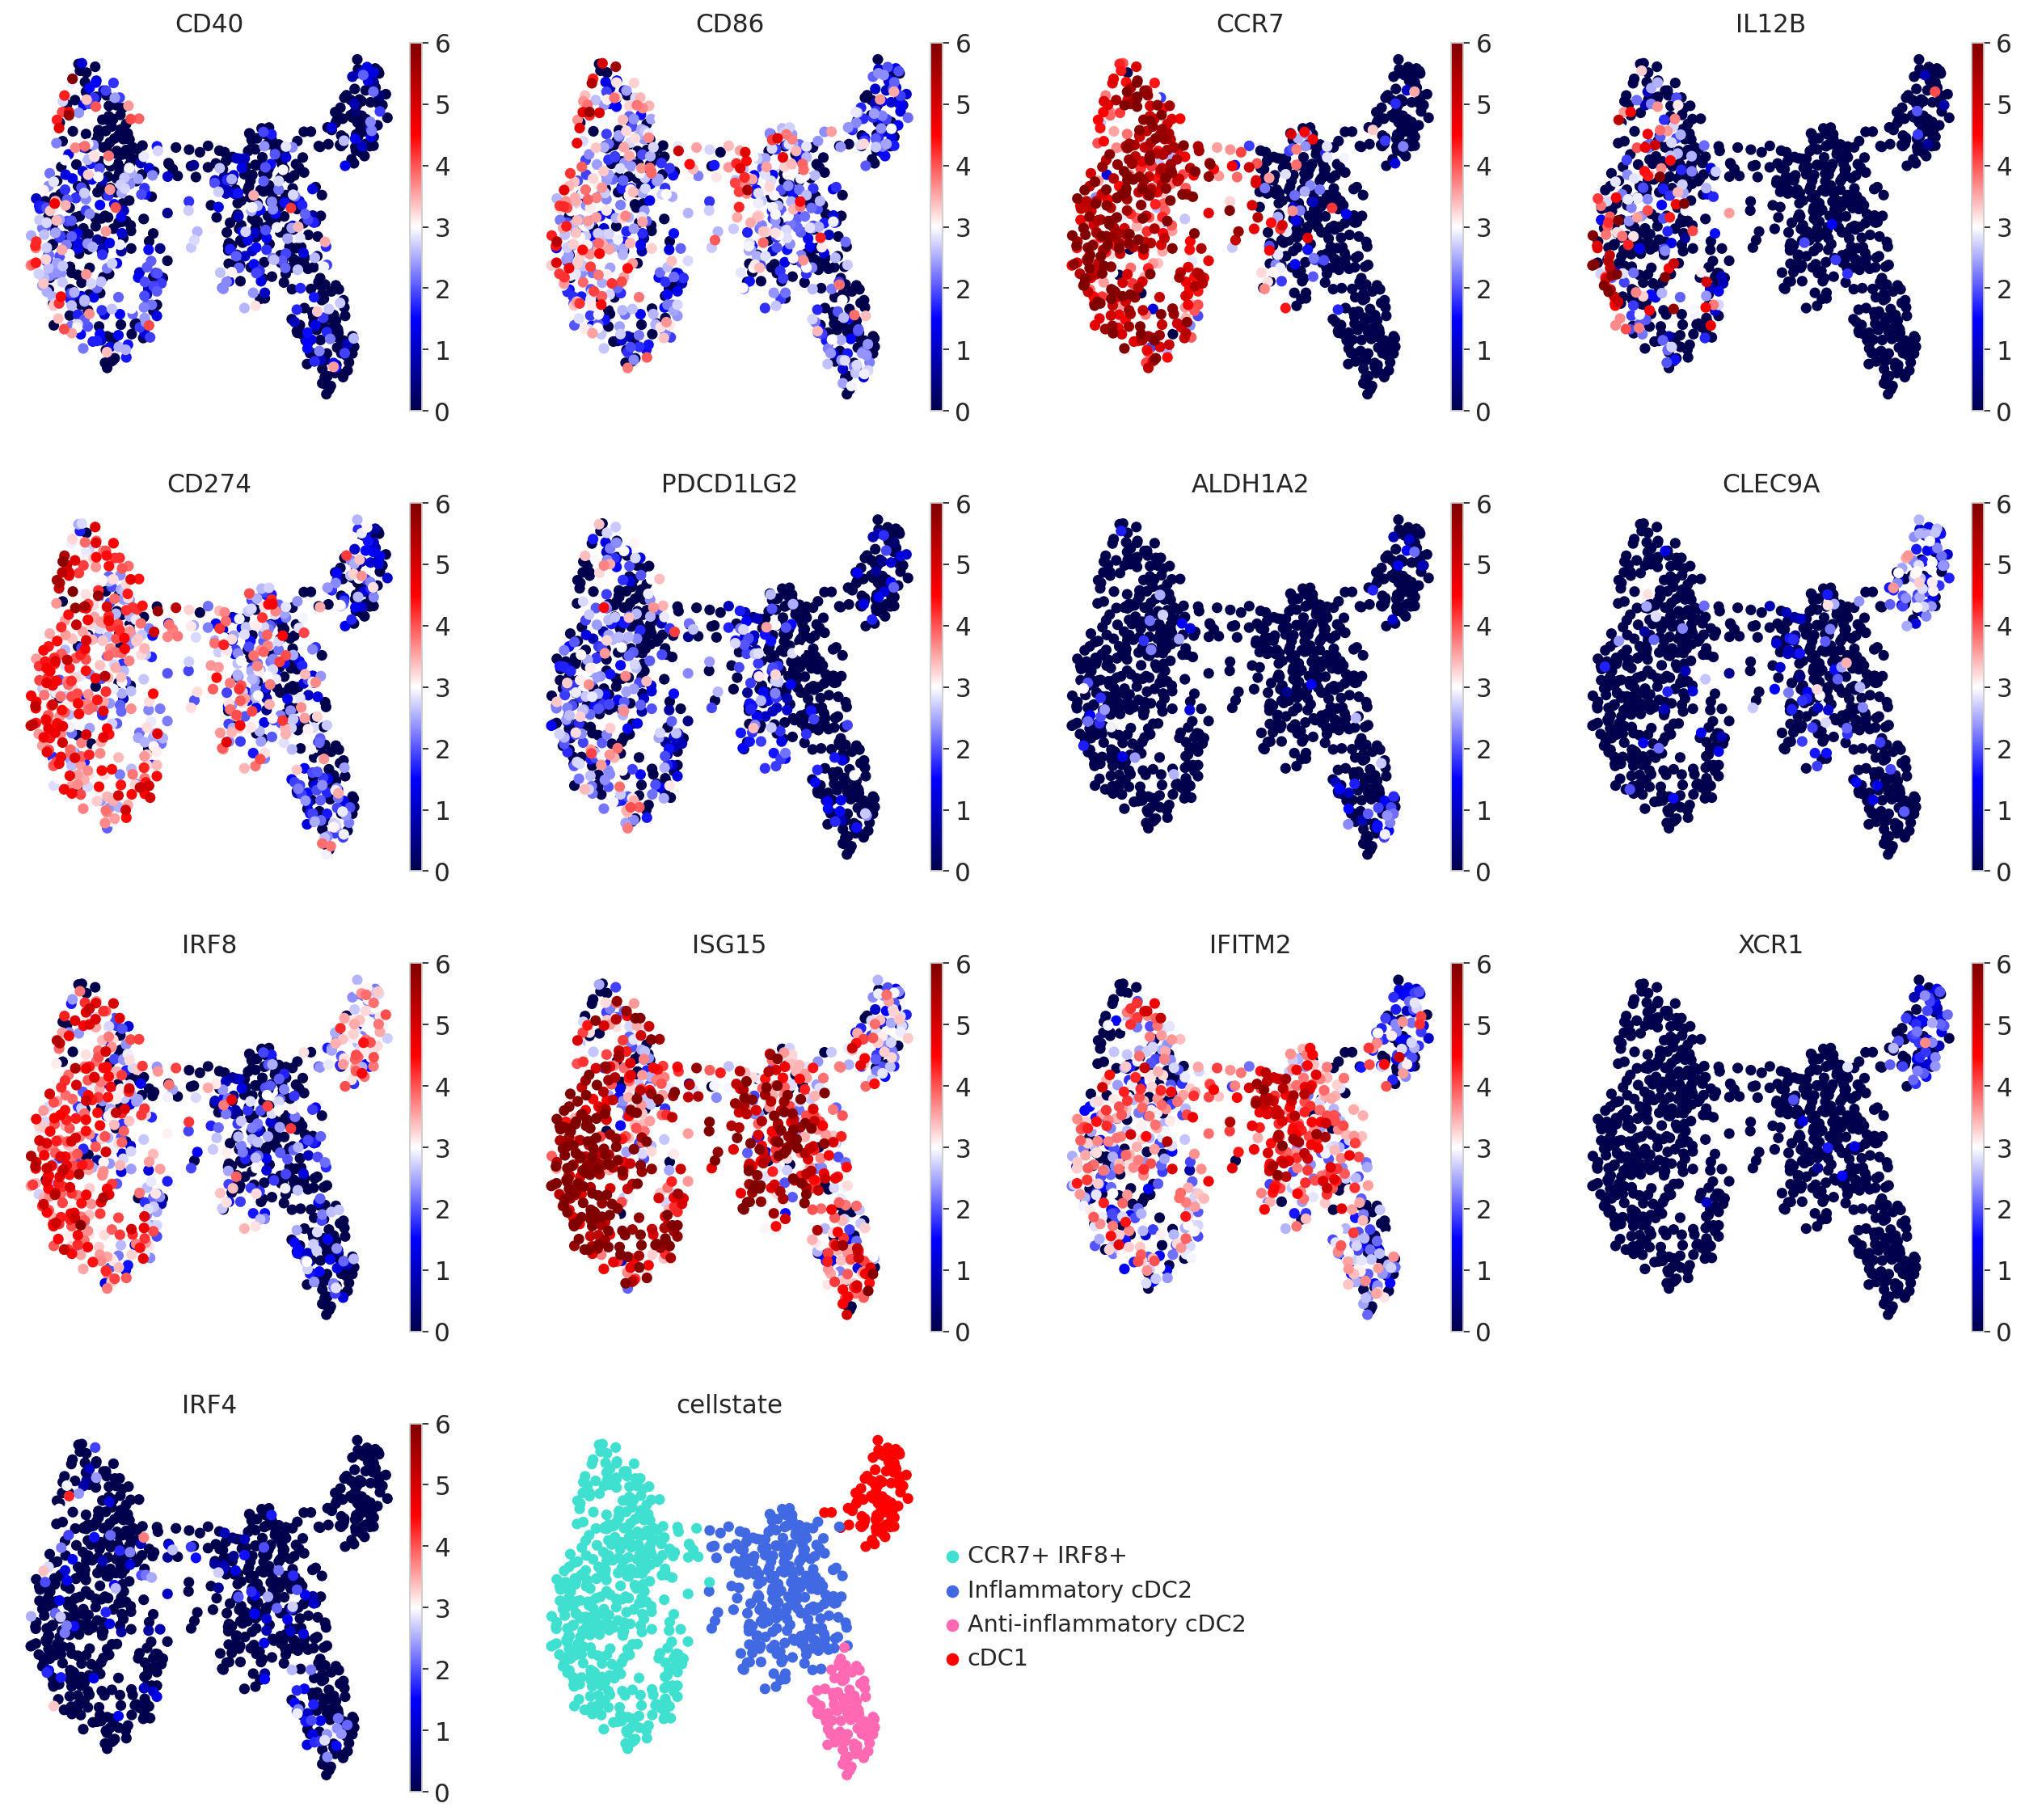

In [10]:
sc.pl.umap(tumor_dc,color = ['CD40','CD86','CCR7','IL12B','CD274','PDCD1LG2','ALDH1A2',
                             'CLEC9A','IRF8','ISG15','IFITM2', 'XCR1','IRF4',
                             'cellstate'],
           palette = {'CCR7+ IRF8+':'turquoise', 'Inflammatory cDC2':'royalblue', 'Anti-inflammatory cDC2':'hotpink', 'cDC1':'red', 
           'Stem-like':'skyblue',  'Proliferation':'gold',
           'Effector':'pink', 'T-reg':'purple',
           'Cytotoxic T cells':'pink',  'Exhausted':'brown', 
                      'Inflammatory':'orange', 'Naive':'skyblue', 'Treg':'purple'}, vmin =0, vmax= 6, cmap = 'seismic',
           frameon = False,ncols = 4) 
           #legend_loc= 'on data', 

## Supplement Figure 6B

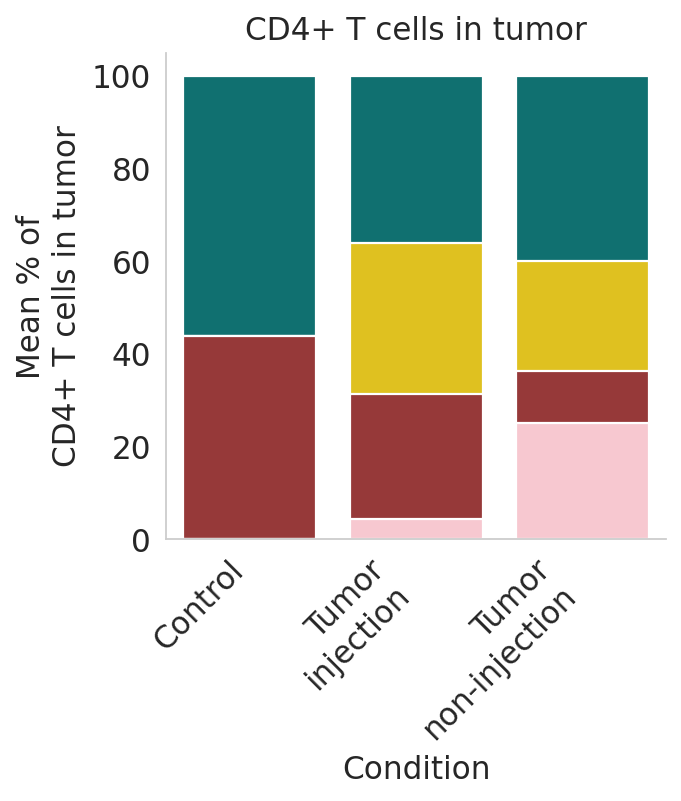

In [13]:
tumor_cd4 = sc.read_h5ad('tumor_cd4_final.h5ad')

quant = tumor_cd4.obs.groupby(by = ['patient','timepoint',])[['total_counts']].count().reset_index()
quant_s = tumor_cd4.obs.groupby(by = ['patient','timepoint','cellstate'])[['ident']].count().reset_index()

quant['pateint_loc'] = quant['timepoint'].astype(str) +quant['patient'].astype(str) 
quant_s['pateint_loc'] = quant_s['timepoint'].astype(str) +quant_s['patient'].astype(str) 

m = quant.merge(quant_s, left_on = 'pateint_loc', right_on  ='pateint_loc')
m['perc'] = m['ident']/m['total_counts']*100
m = m.dropna()

s = m.groupby(by = ['cellstate', 
                    'timepoint_x'])[['perc']].mean().reset_index().pivot_table(index = 'timepoint_x', 
                                                                           columns = 'cellstate', values = 'perc').T

s = s.sort_values(by = ['tumor_inj'],ascending = True)

s = s.cumsum()
s = s.sort_values(by = ['tumor_inj'],ascending = False)
melt = s.reset_index().melt(id_vars = 'cellstate', )
melt['timepoint_x'] = melt['timepoint_x'].map({'tumor':'Control',
                                               'tumor_inj':'Tumor\ninjection',
                                               'tumor_nin':'Tumor\nnon-injection'})

palette = {'Stem-like':'skyblue',  
             'Proliferation':'gold', 
             'Effector memory':'teal', 
             'Effector':'pink',  
             'T-reg':'purple',
             'Pre-exhausted':'orange', 
             'Exhausted':'brown',  }

for name in s.index:
    sns.barplot(data = melt[melt['cellstate'] == name],
            x = 'timepoint_x', y ='value', color= palette[name])
    plt.xlabel('Condition')
    plt.xticks(rotation = 45, ha ='right')
    plt.ylabel('Mean % of\nCD4+ T cells in tumor')
    sns.despine(top = True)
plt.title('CD4+ T cells in tumor')
plt.show()

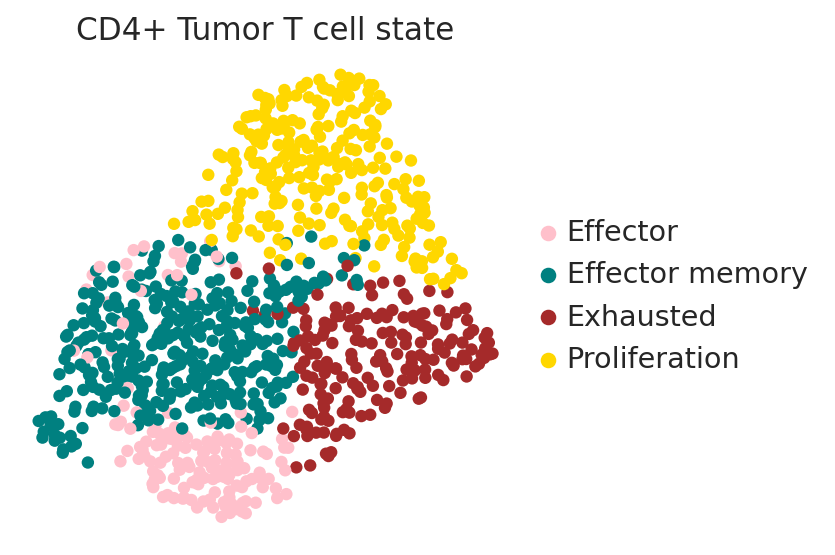

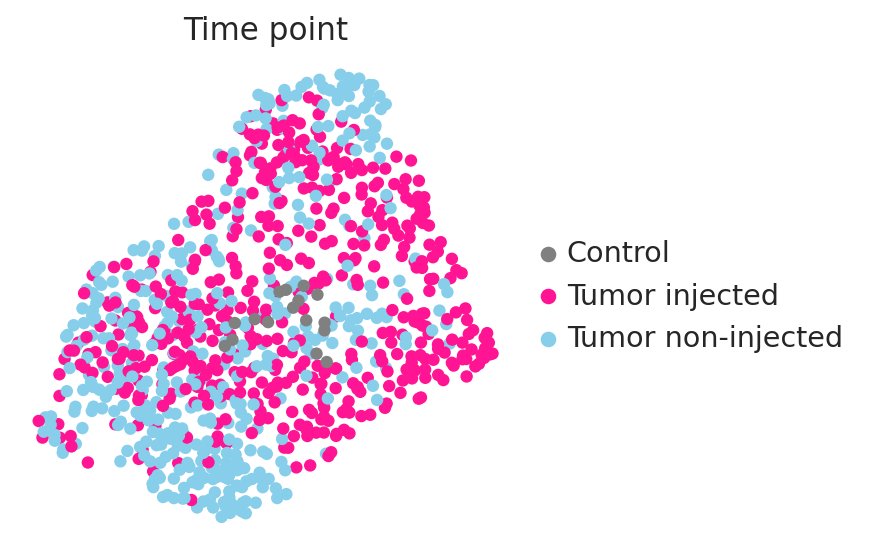

In [15]:
tumor_cd4.obs['timepoint_annot'] = tumor_cd4.obs['timepoint'].map({'tumor':'Control','tumor_inj':'Tumor injected','tumor_nin':'Tumor non-injected'})
sc.pl.umap(tumor_cd4,color = [ 'cellstate'],
           palette = {'Stem-like':'skyblue',  
             'Proliferation':'gold', 
             'Effector memory':'teal', 
             'Effector':'pink',  
             'T-reg':'purple',
             'Pre-exhausted':'orange', 
             'Exhausted':'brown',  }, vmin =0, vmax= 6, cmap = 'seismic',
           title = ['CD4+ Tumor T cell state'],
         #  legend_loc= 'on data',
           frameon = False)

sc.pl.umap(tumor_cd4,color = [ 'timepoint_annot'],
           palette = {'Control':'grey','Tumor injected':'deeppink','Tumor non-injected':'skyblue'},
         vmin =0, vmax= 6, cmap = 'seismic', title = ['Time point'],
           frameon = False)

## Supplement Figure 6C

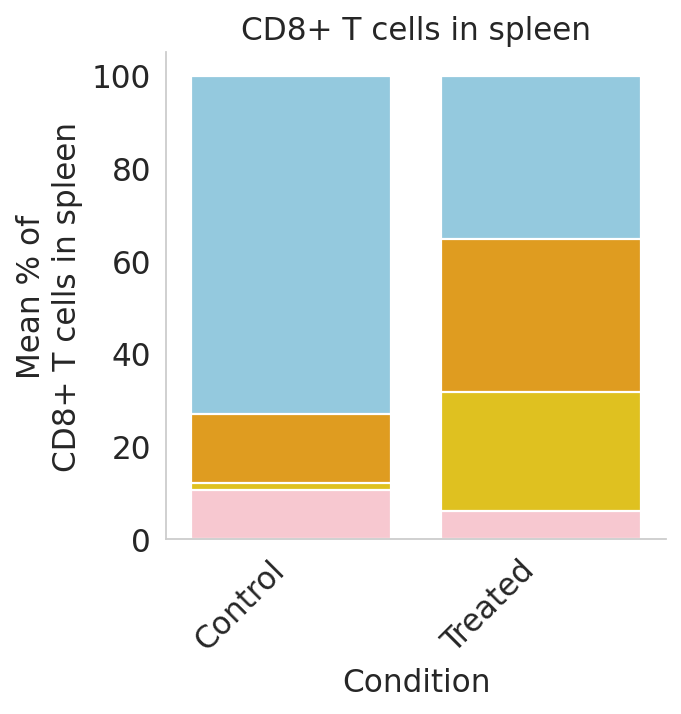

In [18]:
spleen_cd8 = sc.read_h5ad('spleen_cd8_final.h5ad')
quant = spleen_cd8.obs.groupby(by = ['patient','timepoint',])[['total_counts']].count().reset_index()
quant_s = spleen_cd8.obs.groupby(by = ['patient','timepoint','cellstate'])[['ident']].count().reset_index()

quant['pateint_loc'] = quant['timepoint'].astype(str) +quant['patient'].astype(str) 
quant_s['pateint_loc'] = quant_s['timepoint'].astype(str) +quant_s['patient'].astype(str) 

m = quant.merge(quant_s, left_on = 'pateint_loc', right_on  ='pateint_loc')
m['perc'] = m['ident']/m['total_counts']*100
m = m.dropna()

s = m.groupby(by = ['cellstate', 
                    'timepoint_x'])[['perc']].mean().reset_index().pivot_table(index = 'timepoint_x', 
                                                                           columns = 'cellstate', values = 'perc').T


s = s.sort_values(by = ['Treated'],ascending = True)
s = s.cumsum()
s = s.sort_values(by = ['Treated'],ascending = False)

melt = s.reset_index().melt(id_vars = 'cellstate', )
# melt['timepoint_x'] = melt['timepoint_x'].map({'ln':'Control',
#                                                'ln_in':'Tumor\ninjection',
#                                                'ln_nin':'Tumor\nnon-injection'})

for name in s.index:
    sns.barplot(data = melt[melt['cellstate'] == name],
            x = 'timepoint_x', y ='value', color= palette[name])
    plt.xlabel('Condition')
    plt.xticks(rotation = 45, ha ='right')
    plt.ylabel('Mean % of\nCD8+ T cells in spleen')
    sns.despine(top = True)
plt.title('CD8+ T cells in spleen')
plt.show()

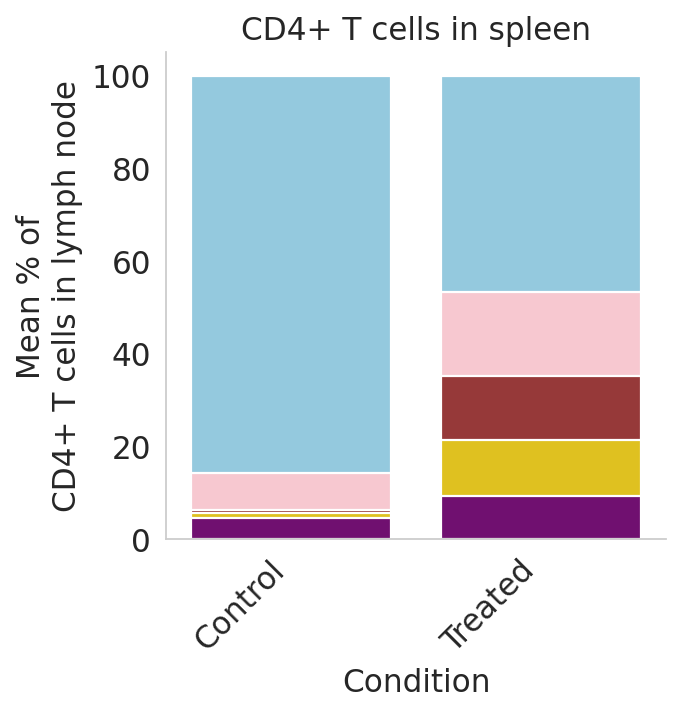

In [17]:
spleen_cd4 = sc.read_h5ad('spleen_cd4_final.h5ad')

quant = spleen_cd4.obs.groupby(by = ['patient','timepoint',])[['total_counts']].count().reset_index()
quant_s = spleen_cd4.obs.groupby(by = ['patient','timepoint','cellstate'])[['ident']].count().reset_index()

quant['pateint_loc'] = quant['timepoint'].astype(str) +quant['patient'].astype(str) 
quant_s['pateint_loc'] = quant_s['timepoint'].astype(str) +quant_s['patient'].astype(str) 

m = quant.merge(quant_s, left_on = 'pateint_loc', right_on  ='pateint_loc')
m['perc'] = m['ident']/m['total_counts']*100
m = m.dropna()

s = m.groupby(by = ['cellstate', 
                    'timepoint_x'])[['perc']].mean().reset_index().pivot_table(index = 'timepoint_x', 
                                                                           columns = 'cellstate', values = 'perc').T


s = s.sort_values(by = ['Treated'],ascending = True)
s = s.cumsum()
s = s.sort_values(by = ['Treated'],ascending = False)

melt = s.reset_index().melt(id_vars = 'cellstate', )
# melt['timepoint_x'] = melt['timepoint_x'].map({'ln':'Control',
#                                                'ln_in':'Tumor\ninjection',
#                                                'ln_nin':'Tumor\nnon-injection'})

for name in s.index:
    sns.barplot(data = melt[melt['cellstate'] == name],
            x = 'timepoint_x', y ='value', color= palette[name])
    plt.xlabel('Condition')
    plt.xticks(rotation = 45, ha ='right')
    plt.ylabel('Mean % of\nCD4+ T cells in lymph node')
    sns.despine(top = True)
plt.title('CD4+ T cells in spleen')
plt.show()

## Supplemental Figure 7A

In [19]:
tumor_bcell_clean = sc.read_h5ad('tumor_bcell_final.h5ad')

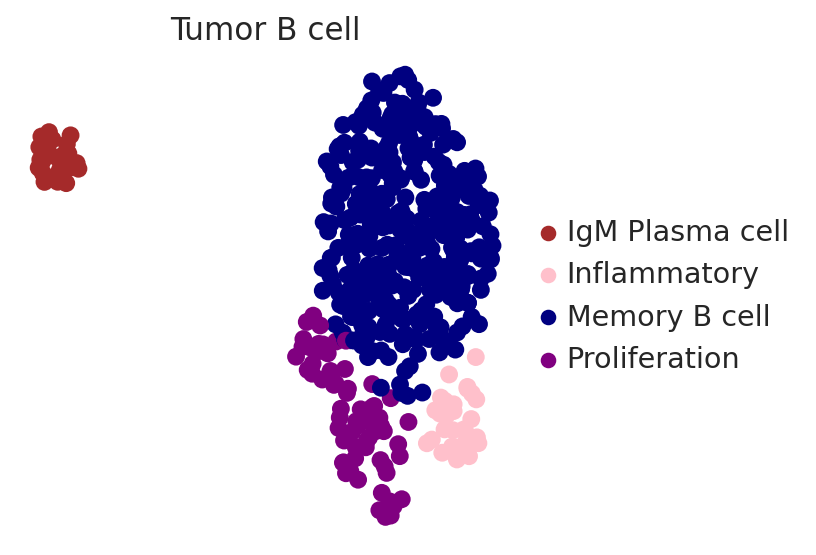

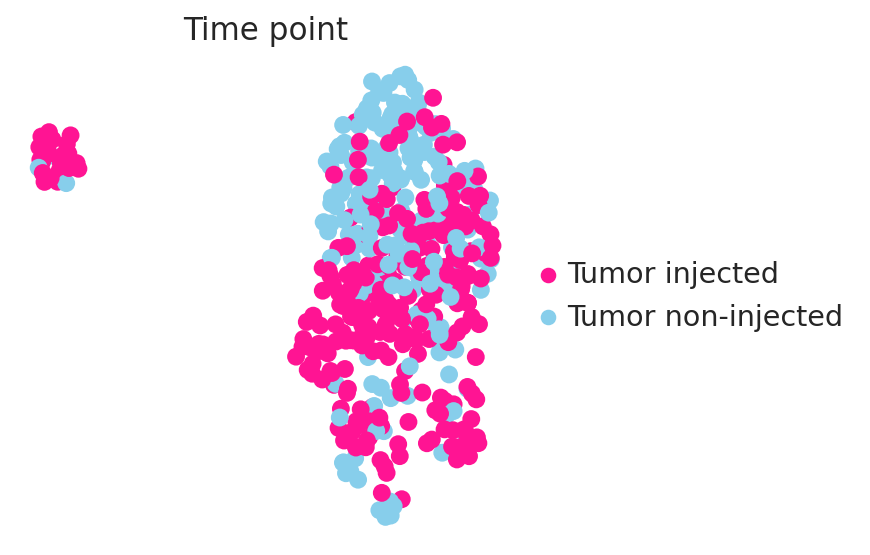

In [21]:
palette = { 'Memory B cell':'navy',  
           'Mature B cell':'teal', 
           'Others':'grey',
             'Inflammatory':'pink',  
             'Proliferation':'purple',
             'IgG Plasma cell':'orange', 
             'IgM Plasma cell':'brown',  }

sc.pl.umap(tumor_bcell_clean, color =[ 'cellstate'],
           vmin =0 ,  palette=palette,
           vmax = 5, cmap = 'seismic', title=['Tumor B cell'],frameon = False,
           ncols = 5)

sc.pl.umap(tumor_bcell_clean,color = [ 'timepoint_annot'],
           palette = {'Control':'grey','Tumor injected':'deeppink','Tumor non-injected':'skyblue'},
         vmin =0, vmax= 6, cmap = 'seismic', title = ['Time point'],
           frameon = False)

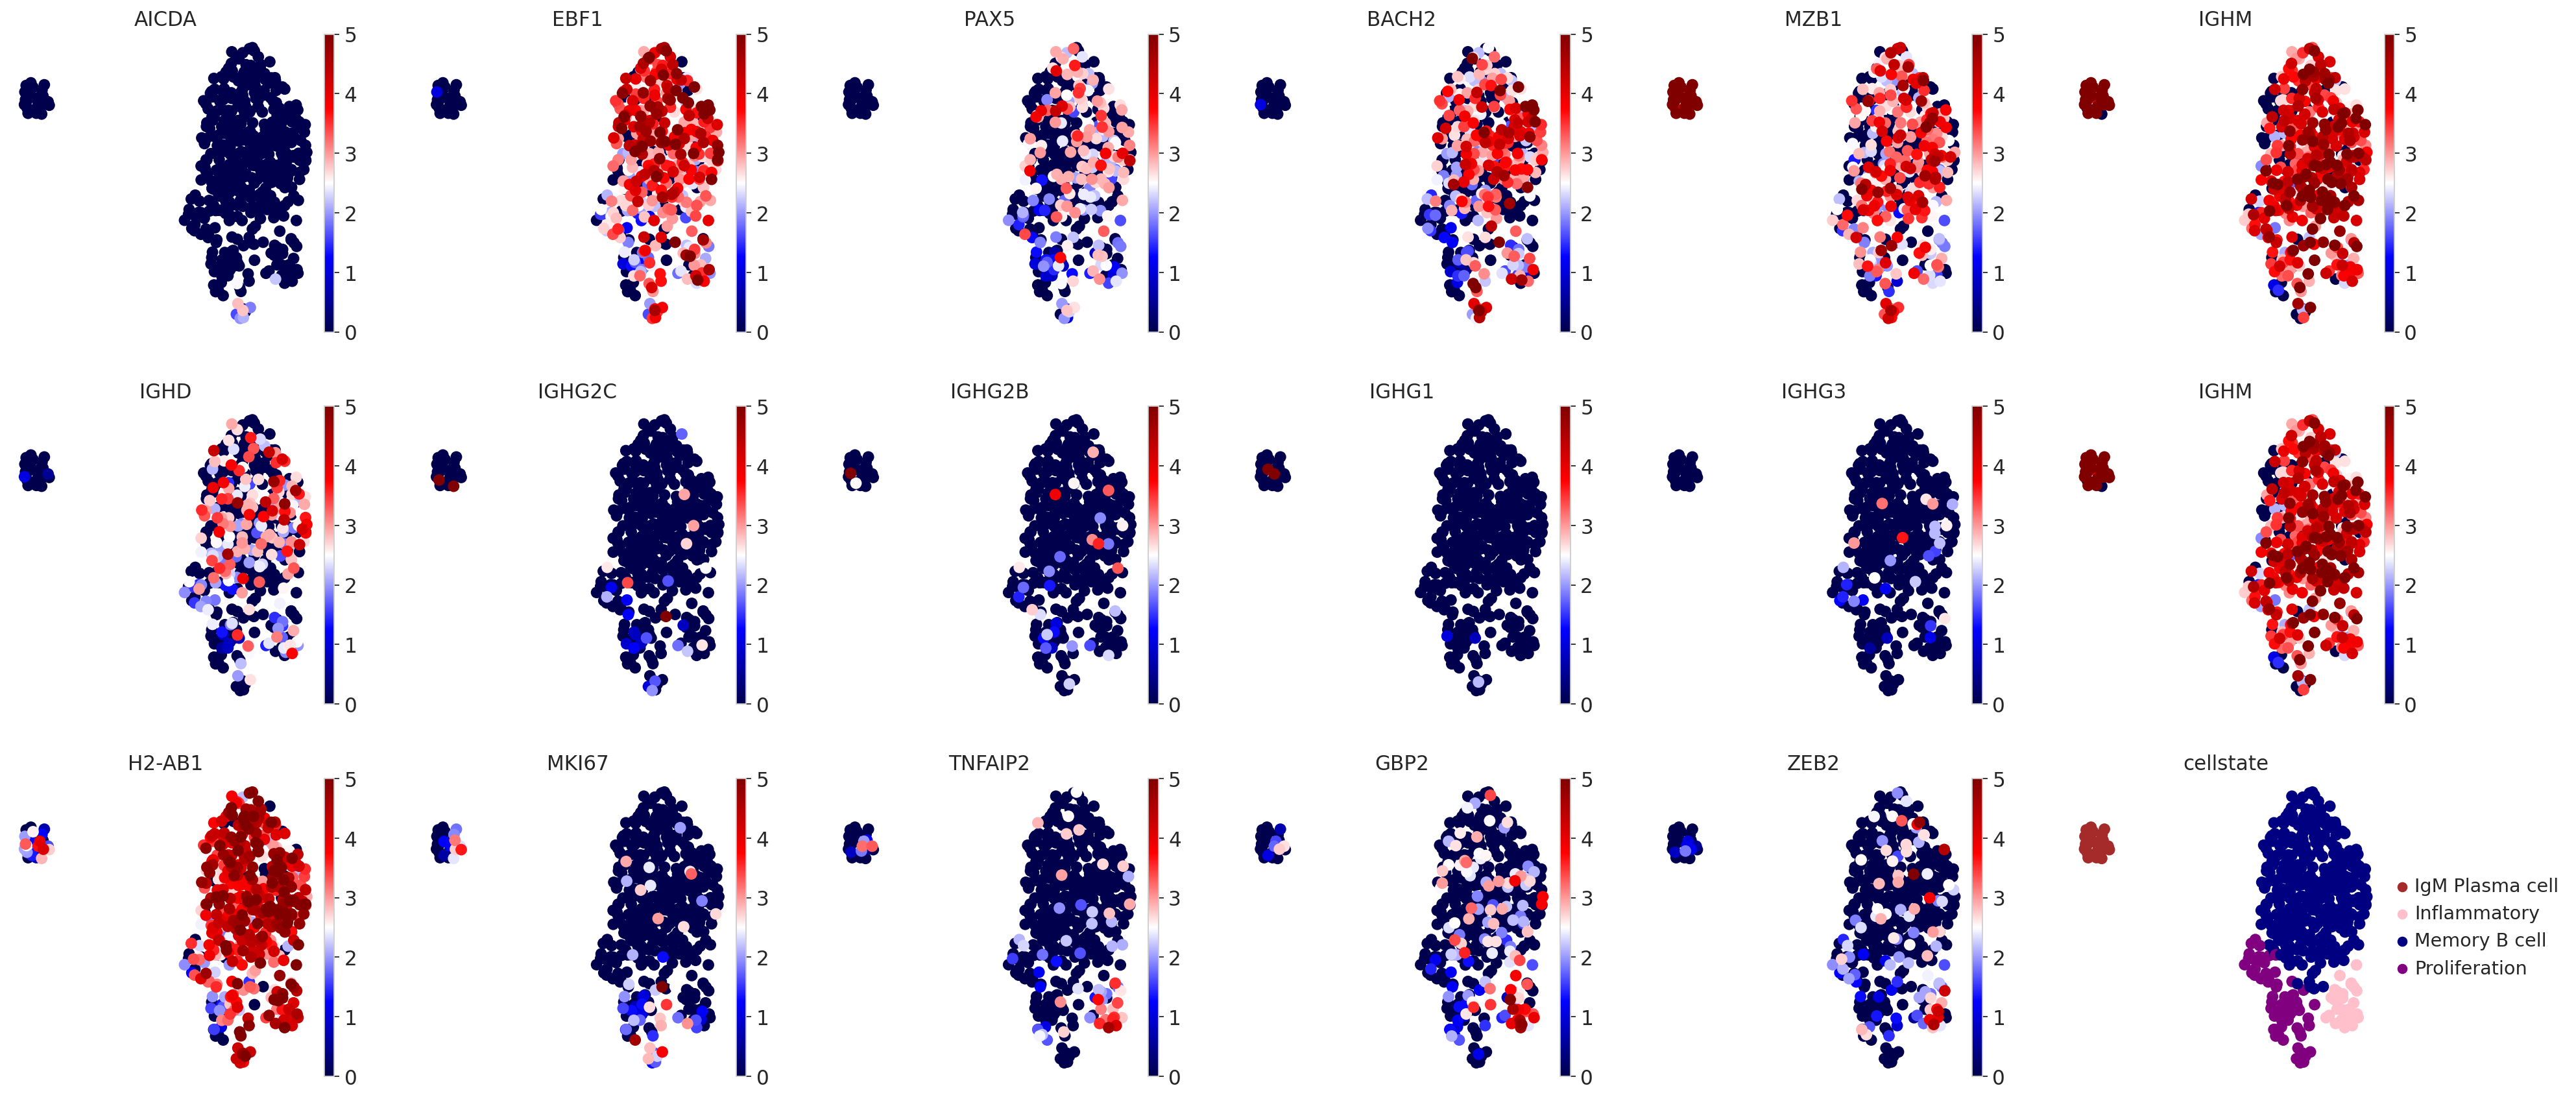

In [22]:
sc.pl.umap(tumor_bcell_clean, color =[ 'AICDA','EBF1','PAX5','BACH2','MZB1','IGHM','IGHD', 'IGHG2C', 'IGHG2B', 'IGHG1', 'IGHG3','IGHM',
                                      'H2-AB1', 'MKI67','TNFAIP2','GBP2','ZEB2','cellstate'],
           vmin =0 ,   vmax = 5, cmap = 'seismic', frameon = False,  ncols = 6)

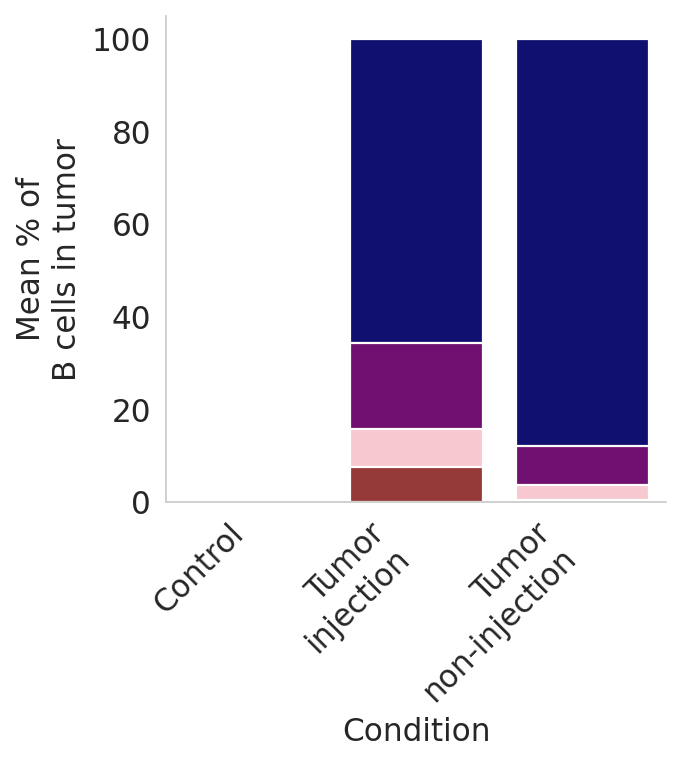

In [23]:
quant = tumor_bcell_clean.obs.groupby(by = ['patient','timepoint',])[['total_counts']].count().reset_index()
quant_s = tumor_bcell_clean.obs.groupby(by = ['patient','timepoint','cellstate'])[['ident']].count().reset_index()

quant['pateint_loc'] = quant['timepoint'].astype(str) +quant['patient'].astype(str) 
quant_s['pateint_loc'] = quant_s['timepoint'].astype(str) +quant_s['patient'].astype(str) 

m = quant.merge(quant_s, left_on = 'pateint_loc', right_on  ='pateint_loc')
m['perc'] = m['ident']/m['total_counts']*100
m = m.dropna()


s = m.groupby(by = ['cellstate', 
                    'timepoint_x'])[['perc']].mean().reset_index().pivot_table(index = 'timepoint_x', 
                                                                           columns = 'cellstate', values = 'perc').T

s = s.sort_values(by = ['tumor_inj'],ascending = True)

s = s.cumsum()
s = s.sort_values(by = ['tumor_inj'],ascending = False)
melt = s.reset_index().melt(id_vars = 'cellstate', )
melt['timepoint_x'] = melt['timepoint_x'].map({'tumor':'Control',
                                               'tumor_inj':'Tumor\ninjection','tumor_nin':'Tumor\nnon-injection'})

melt['timepoint_x'] = pd.Categorical(melt['timepoint_x'],['Control','Tumor\ninjection','Tumor\nnon-injection'])


for name in s.index:
    sns.barplot(data = melt[melt['cellstate'] == name], 
                x = 'timepoint_x', y ='value', color= palette[name])
    plt.xlabel('Condition')
    plt.xticks(rotation = 45, ha ='right')
    plt.ylabel('Mean % of\nB cells in tumor')
    sns.despine(top = True)
plt.show()